In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import os
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_parquet(r'F:\minowa\BloodPressureEstimation\data\processed\PulseDB\Downsampled\train_features.parquet').drop('Unnamed: 0', axis=1, errors='ignore')  
test_df = pd.read_parquet(r'F:\minowa\BloodPressureEstimation\data\processed\PulseDB\ppg_features_pulsedb_test_all.parquet' ).drop('Unnamed: 0', axis=1, errors='ignore')


In [3]:
test_df.columns.tolist()

['Tc',
 'Ts',
 'Td',
 'Tsteepest',
 'Steepest',
 'TNegSteepest',
 'NegSteepest',
 'TdiaRise',
 'DiaRise',
 'SteepDiaRise',
 'TSystoDiaRise',
 'TdiaToEnd',
 'Ratio',
 'Ts_norm',
 'Td_norm',
 'Tsteepest_norm',
 'TNegSteepest_norm',
 'TdiaRise_norm',
 'TSystoDiaRise_norm',
 'TdiaToEnd_norm',
 'SW25',
 'SW25_norm',
 'DW25',
 'DW25_norm',
 'SWaddDW25',
 'SWaddDW25_norm',
 'DWdivSW25',
 'SW50',
 'SW50_norm',
 'DW50',
 'DW50_norm',
 'SWaddDW50',
 'SWaddDW50_norm',
 'DWdivSW50',
 'SW75',
 'SW75_norm',
 'DW75',
 'DW75_norm',
 'SWaddDW75',
 'SWaddDW75_norm',
 'DWdivSW75',
 'S1',
 'S2',
 'S3',
 'S4',
 'AUCsys',
 'AUCdia',
 'S1_norm',
 'S2_norm',
 'S3_norm',
 'S4_norm',
 'AUCsys_norm',
 'AUCdia_norm',
 'SQI_skew',
 'SQI_kurtosis',
 'apg_a',
 'apg_b',
 'apg_c',
 'apg_d',
 'apg_e',
 'ppg_a',
 'ppg_b',
 'ppg_c',
 'ppg_d',
 'ppg_e',
 'ratio_apg_b',
 'ratio_apg_c',
 'ratio_apg_d',
 'ratio_apg_e',
 'ratio_ppg_b',
 'ratio_ppg_c',
 'ratio_ppg_d',
 'ratio_ppg_e',
 'T_a',
 'T_b',
 'T_c',
 'T_d',
 'T_e',
 'T

In [3]:
def classify_ppg_morphology(df):
    a = df['apg_a'].values
    b = df['apg_b'].values
    c = df['apg_c'].values
    d = df['apg_d'].values
    e = df['apg_e'].values
    smallest = df[['apg_a','apg_b','apg_c','apg_d']].min(axis=1)
    is_d_closeto_b = ((b-d) < b/3) & (b - d >= 0) 
    is_c_closeto_b =  ((b-c) < b/3) & (b - c >=0)
    is_bc_flat = (np.abs(c - b) < b/10)
    bdc = (b <= d) & (d <= c)
    dbc = (d <= b) & (b <= c)
    dcb = (d <= c) & (c <= b)
    dc = (d <= c) 
    conditions = [
        (a > 0) & (b < 0) & (c > 0) & (d < 0) , 
        (a > 0) & (b < 0) & (c < 0) & (d < 0) & (bdc) & (~is_d_closeto_b),
        (a > 0) & (b < 0) & (c < 0) & (d < 0) & (bdc) & (is_d_closeto_b) & (~is_c_closeto_b),
        (a > 0) & (b < 0) & (c < 0) & (d < 0) & (bdc) & (is_c_closeto_b) & (is_d_closeto_b),
        (a > 0) & (b < 0) & (c < 0) & (d < 0) & (dbc) & (~is_bc_flat),
        (a > 0) & (b < 0) & (c < 0) & (d < 0) & (dc) & (is_bc_flat),
        (a > 0) & (b < 0) & (c < 0) & (d < 0) & (dc) & (~is_bc_flat),
        (a > 0) & (b < 0) & (c > 0) & (d > 0),
        np.isclose(a, b) & np.isclose(b, c) & np.isclose(c, d)
    ]
    choices = [0,1,2,3,4,5,6,7,-10]
    df['ppg_morphology_class'] = np.select(conditions, choices, default=-1)
    df['sign_a']  = np.sign(df['apg_a'])
    df['sign_b']  = np.sign(df['apg_b'])
    df['sign_c']  = np.sign(df['apg_c'])
    df['sign_d']  = np.sign(df['apg_d'])
    df['d_close_to_b'] = is_d_closeto_b.astype(int)
    df['c_close_to_b'] = is_c_closeto_b.astype(int)
    df['bc_flat'] = is_bc_flat.astype(int)
    df['bdc'] = bdc.astype(int)
    df['dbc'] = dbc.astype(int)
    df['dcb'] = dcb.astype(int)
    df['dc'] = dc.astype(int)
    df['smallest_abcd'] = smallest
    print(df['ppg_morphology_class'].value_counts())
    

In [4]:
classify_ppg_morphology(test_df)

ppg_morphology_class
-1     50897
 1     24805
 0      9273
 7      2575
-10     1355
 4      1349
 6        35
Name: count, dtype: int64


In [5]:
a = test_df['apg_a'].values
b = test_df['apg_b'].values
c = test_df['apg_c'].values
d = test_df['apg_d'].values
is_d_closeto_b = ((b-d) < b/3) & (b - d >= 0) 
is_c_closeto_b =  ((b-c) < b/3) & (b - c >=0)
is_bc_flat = (np.abs(c - b) < b/10)
bdc = (b <= d) & (d <= c)
dbc = (d <= b) & (b <= c)
dcb = (d <= c) & (c <= b)
dc = (d <= c) 

In [58]:
conditions = [
    (a > 0) & (b < 0) & (c > 0) & (d < 0) , 
    (a > 0) & (b < 0) & (c < 0) & (d < 0) & (bdc) & (~is_d_closeto_b),
    (a > 0) & (b < 0) & (c < 0) & (d < 0) & (bdc) & (is_d_closeto_b) & (~is_c_closeto_b),
    (a > 0) & (b < 0) & (c < 0) & (d < 0) & (bdc) & (is_c_closeto_b) & (is_d_closeto_b)
    (a > 0) & (b < 0) & (c < 0) & (d < 0) & (dbc) & (~is_bc_flat),
    (a > 0) & (b < 0) & (c < 0) & (d < 0) & (dc) & (is_bc_flat),
    (a > 0) & (b < 0) & (c < 0) & (d < 0) & (dc) & (~is_bc_flat),
    (a > 0) & (b < 0) & (c > 0) & (d > 0)
]
choices = [0,1,2,3,4,5,6,7]
test_df['ppg_morphology_class'] = np.select(conditions, choices, default=-1)

TypeError: 'numpy.ndarray' object is not callable

In [7]:
cols_to_display = ['apg_a','apg_b','apg_c','apg_d','sign_a','sign_b','sign_c','sign_d','ppg_morphology_class','d_close_to_b','c_close_to_b','bc_flat','bdc','dbc','dcb','dc','smallest_abcd']

In [43]:
test_df[test_df['ppg_morphology_class'] == -1][cols_to_display]

,apg_a,apg_b,apg_c,apg_d,sign_a,sign_b,sign_c,sign_d,ppg_morphology_class,d_close_to_b,c_close_to_b,bc_flat,bdc,dbc,dcb,dc,smallest_abcd
1,0.006800,-0.008833,-0.005365,-0.004830,1.0,-1.0,-1.0,-1.0,-1,0,0,0,0,0,0,0,-0.008833
3,0.008416,-0.012257,-0.010303,-0.009961,1.0,-1.0,-1.0,-1.0,-1,0,0,0,0,0,0,0,-0.012257
4,0.009156,-0.013406,-0.010695,-0.010618,1.0,-1.0,-1.0,-1.0,-1,0,0,0,0,0,0,0,-0.013406
5,0.007241,-0.011142,-0.006649,-0.006616,1.0,-1.0,-1.0,-1.0,-1,0,0,0,0,0,0,0,-0.011142
7,0.008742,-0.011849,-0.008775,-0.008771,1.0,-1.0,-1.0,-1.0,-1,0,0,0,0,0,0,0,-0.011849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90240,0.005998,-0.006424,-0.002028,-0.002010,1.0,-1.0,-1.0,-1.0,-1,0,0,0,0,0,0,0,-0.006424
90251,0.006314,-0.005427,-0.002472,-0.002350,1.0,-1.0,-1.0,-1.0,-1,0,0,0,0,0,0,0,-0.005427
90268,0.006327,-0.005402,-0.002100,-0.002090,1.0,-1.0,-1.0,-1.0,-1,0,0,0,0,0,0,0,-0.005402
90270,0.004432,-0.004201,-0.003115,-0.003038,1.0,-1.0,-1.0,-1.0,-1,0,0,0,0,0,0,0,-0.004201


In [6]:
ppg = np.load(r'F:\minowa\BloodPressureEstimation\data\processed\PulseDB\test_ppg.npy')
ppg.shape

(111600, 1250)

In [25]:
test_df.shape

(90289, 115)

In [83]:
target['sign_c'].value_counts()

sign_c
-1.0    50348
 1.0      549
Name: count, dtype: int64

8529.0
apg_a                   0.006072
apg_b                  -0.007855
apg_c                  -0.004186
apg_d                  -0.003903
sign_a                  1.000000
sign_b                 -1.000000
sign_c                 -1.000000
sign_d                 -1.000000
ppg_morphology_class   -1.000000
d_close_to_b            0.000000
c_close_to_b            0.000000
bc_flat                 0.000000
bdc                     0.000000
dbc                     0.000000
dcb                     0.000000
dc                      0.000000
smallest_abcd          -0.007855
Name: 6480, dtype: float64


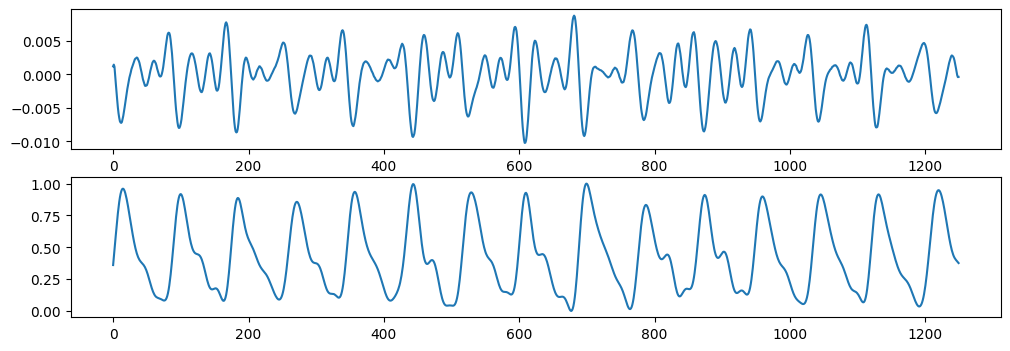

In [8]:
target = test_df[(test_df['ppg_morphology_class'] == -1)]
index = np.random.randint(0, len(target))
print(target.iloc[index]['signal_index'])
print(target.iloc[index][cols_to_display])
target_ppg = ppg[int(target.iloc[index]['signal_index'])]
target_apg = np.gradient(target_ppg)
target_apg = np.gradient(target_apg)
# plt.plot(target_ppg)
plt.subplots(2,1, figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(target_apg)
# plt.xlim(200, 600)
plt.subplot(2,1,2)
plt.plot(target_ppg)    
# plt.xlim(200, 600)

In [38]:
def _extract_ppg_cycles(df):
    """ Compute and save the ppg cycles in dataframe.
        This function updates filtered signal. 
    """
    def _extract_c(sig, fs, pk_th=0.6, remove_start_end=False):
        """ Wrapper for extract_cycle_check function. """
        try:
            cs, pks_norm, flag1, flag2, pks, vlys = features_extraction.extract_cycle_check(sig, fs, pk_th, remove_start_end)
        except:
            cs, pks_norm, flag1, flag2, pks, vlys = [], [], True, True, [], []
        return cs, pks_norm, flag1, flag2, pks, vlys

    c_ppg = Parallel(n_jobs=-1)(delayed(_extract_c)(sig, fs=125, remove_start_end=False) for sig in df.fsignal)

    for i, label in enumerate(['cs','pks_norm','ppg_f1','ppg_f2','ppg_pks','ppg_vlys']):
        df[label] = [val[i] for val in c_ppg]
    not_computed = ((df['ppg_pks'].map(len)==0) | (df['ppg_f2']))
    # cl_log.write(" - removed by not computed: {} \n".format((not_computed).sum()))
    df = df[~not_computed].reset_index(drop=True)

    return df

def _wrapper_compute_features_parallel(df):
    # 並列で処理する関数を定義
    def process_row(row):
        try:
            feat_name, feats = features_extraction.extract_feat_cycle(row.cs, row.pks_norm, fs=fs,mean=False)
            # feat_name = np.append(feat_name,"signal_index")
            # feats = np.append(feats,row.signal_index)
            return feat_name, feats
        except Exception as e:
            # print(e)
            return None  # 失敗した場合はNoneを返す
    
    # df.iterrows()の各行に対してprocess_rowを並列に適用
    # heads_feats = Parallel(n_jobs=-1)(
    #     delayed(process_row)(row) for _, row in df.iterrows()
    # )
    heads_feats = [process_row(row)for _,row in df.iterrows()]
    
    # Noneを取り除く
    heads_feats = [feat for feat in heads_feats if feat is not None]

    return heads_feats

In [39]:
# for j in trange(len(ppg_chunk)):
#     tmp = {"fsignal":[],"signal_index":[]}
#     tmp["fsignal"].append(ppg_chunk[j])
#     tmp["signal_index"].append(i+j)
#     a = pd.DataFrame(tmp)
#     df = pd.concat([df,a])
import features_extraction
from joblib import Parallel, delayed
fs = 125
# from features_extraction import _extract_ppg_cycles, _wrapper_compute_features_parallel
df = pd.DataFrame(columns=['fsignal','signal_index'])
dic = {"fsignal": [target_ppg], "signal_index":[0]}
df = pd.DataFrame(dic)
df = df.reset_index(drop=True)
df = _extract_ppg_cycles(df)
heads_feats = _wrapper_compute_features_parallel(df)
list_2 = []
for k,(h,f) in enumerate(heads_feats):
    if len(h)==0 or len(f) == 0:
        list_2.append(k)

list_series = [pd.Series(f, index=h, dtype='float64') for h,f in heads_feats]
res_second = pd.DataFrame(list_series)
heads_feats_first = Parallel(n_jobs=-1)(delayed(features_extraction.extract_feat_original)(fsig, fs=fs, filtered = True, remove_start_end=False) for fsig in df['fsignal'])
list_2_1 = []
for l,(h,f) in enumerate(heads_feats_first):
    if len(h)==0 or len(f) == 0:
        list_2_1.append(l)
        

list_series = [pd.Series(f, index=h, dtype='float64') for h,f in heads_feats_first]
res = pd.DataFrame(list_series)

template = pd.read_csv("columns_template.csv")['columns'].values
data_feats = res_second
keep_mask = ~data_feats.isna()['bd']

# data_feats = data_feats[keep_mask].reset_index(drop=True)
# df = df[keep_mask].reset_index(drop=True)

data_feats = data_feats.replace([np.inf, -np.inf], 0)
data_feats['signal_index']= data_feats['signal_index'].astype('int')


ValueError: Length of values (14) does not match length of index (98)

In [59]:
df

,fsignal,signal_index,cs,pks_norm,ppg_f1,ppg_f2,ppg_pks,ppg_vlys
0,"[0.3602954958674723, 0.4173956358914156, 0.476...",0,"[[0.3602954958674723, 0.4173956358914156, 0.47...","[14, 25, 21, 26, 24, 33, 27, 22, 22, 23, 37, 2...",False,False,"[14, 100, 184, 271, 357, 443, 529, 610, 699, 7...","[0, 75, 163, 245, 333, 410, 502, 588, 677, 764..."


In [40]:
heads_feats

[(array(['Tc', 'Ts', 'Td', 'Tsteepest', 'Steepest', 'TNegSteepest',
         'NegSteepest', 'TdiaRise', 'DiaRise', 'SteepDiaRise',
         'TSystoDiaRise', 'TdiaToEnd', 'Ratio', 'Ts_norm', 'Td_norm',
         'Tsteepest_norm', 'TNegSteepest_norm', 'TdiaRise_norm',
         'TSystoDiaRise_norm', 'TdiaToEnd_norm', 'SW25', 'SW25_norm',
         'DW25', 'DW25_norm', 'SWaddDW25', 'SWaddDW25_norm', 'DWdivSW25',
         'SW50', 'SW50_norm', 'DW50', 'DW50_norm', 'SWaddDW50',
         'SWaddDW50_norm', 'DWdivSW50', 'SW75', 'SW75_norm', 'DW75',
         'DW75_norm', 'SWaddDW75', 'SWaddDW75_norm', 'DWdivSW75', 'S1',
         'S2', 'S3', 'S4', 'AUCsys', 'AUCdia', 'S1_norm', 'S2_norm',
         'S3_norm', 'S4_norm', 'AUCsys_norm', 'AUCdia_norm', 'SQI_skew',
         'SQI_kurtosis', 'apg_a', 'apg_b', 'apg_c', 'apg_d', 'apg_e',
         'ppg_a', 'ppg_b', 'ppg_c', 'ppg_d', 'ppg_e', 'ratio_apg_b',
         'ratio_apg_c', 'ratio_apg_d', 'ratio_apg_e', 'ratio_ppg_b',
         'ratio_ppg_c', 'ratio_ppg_

In [41]:
h = heads_feats[0][0]
f = heads_feats[0][1]
h.shape, f.shape

((98,), (14, 98))

In [43]:
type(h)

numpy.ndarray

In [63]:
df["ppg_pks"].values[0]

[14, 100, 184, 271, 357, 443, 529, 610, 699, 787, 874, 959, 1045, 1131]

In [71]:
df["ppg_vlys"].values[0]

array([   0,   75,  163,  245,  333,  410,  502,  588,  677,  764,  837,
        936, 1019, 1108, 1191], dtype=int64)

In [74]:
f_a = f[:,np.where(h == 'apg_a')[0]].flatten()
f_b = f[:,np.where(h == 'apg_b')[0]].flatten()
f_c = f[:,np.where(h == 'apg_c')[0]].flatten()
f_d = f[:,np.where(h == 'apg_d')[0]].flatten()
f_e = f[:,np.where(h == 'apg_e')[0]].flatten()
# [a/fs,(b-a)/fs,(c-b)/fs,(d-c)/fs,(e-d)/fs]
T_a = f[:,np.where(h == 'T_a')[0]]
T_b = f[:,np.where(h == 'T_b')[0]]+T_a
T_c = f[:,np.where(h == 'T_c')[0]]+T_b
T_d = f[:,np.where(h == 'T_d')[0]]+T_c
T_e = f[:,np.where(h == 'T_e')[0]]+T_d
T_a = (T_a * fs).flatten() + df["ppg_vlys"].values[0][:-1]
T_b = (T_b * fs).flatten()+ df["ppg_vlys"].values[0][:-1]
T_c = (T_c * fs).flatten()+ df["ppg_vlys"].values[0][:-1]
T_d = (T_d * fs).flatten()+ df["ppg_vlys"].values[0][:-1]
T_e = (T_e * fs).flatten()+ df["ppg_vlys"].values[0][:-1]

In [68]:
f_a

array([0.00235717, 0.00619598, 0.0078364 , 0.00485635, 0.00668341,
       0.00479733, 0.00630004, 0.00719201, 0.00885239, 0.00660696,
       0.00307537, 0.0068602 , 0.00596829, 0.00742326])

In [55]:
target_apg = np.diff(np.diff(target_ppg))
target_apg.shape

(1248,)

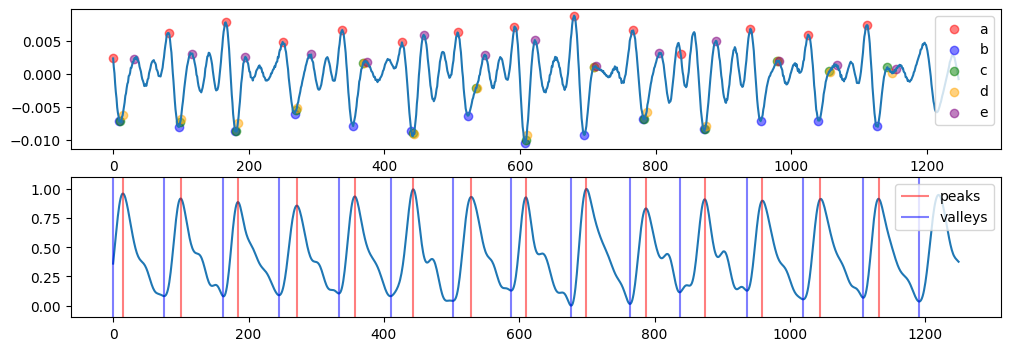

In [79]:
plt.subplots(2,1, figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(target_apg)
plt.scatter(T_a, f_a, color='red', label='a', alpha=0.5)
plt.scatter(T_b, f_b, color='blue', label='b', alpha=0.5)
plt.scatter(T_c, f_c, color='green', label='c', alpha=0.5)
plt.scatter(T_d, f_d, color='orange', label='d', alpha=0.5)
plt.scatter(T_e, f_e, color='purple', label='e',     alpha=0.5)
plt.legend()
# plt.xlim(200, 600)
plt.subplot(2,1,2)
plt.plot(target_ppg)
plt.vlines(np.array(df['ppg_pks'].values[0]), ymin=-0.1, ymax=1.1,label='peaks', color='red',alpha=0.5)
plt.vlines(np.array(df['ppg_vlys'].values[0]), ymin=-0.10, ymax=1.1, label='valleys', color='blue',alpha=0.5)    
plt.ylim(-0.1, 1.1)  
plt.legend()